## **University of Illinois Chicago**
CS 418 - Fall 2024 Team 5

## **Data-Driven Course Insights: Predicting Grade Trends**

## **Authors:**
| **Name**  | **Email** | **Github Handle** |
|---|---|---|
| Arlette Diaz | adiaz218@uic.edu | adiaz218 |
| Marianne Hernandez | mhern85@uic.edu | marhern19 |
| Nandini Jirobe | njiro2@uic.edu | nandinijirobe |
| Sharadruthi Muppidi | smuppi2@uic.edu | sharadruthi-uic |
| Sonina Mut | smut3@uic.edu | snina22 |
| Yuting Lu | lyuti@uic.edu | yutinglu103 |

**Github Repository Link: https://github.com/cs418-fa24/project-check-in-team-5**

## **Project Description**

This project is to predict course grade distributions and popularity rankings for upcoming semesters, enabling students to make informed decisions about their class selections. By shifting the focus from individual grade predictions to overall course outcomes, the project provides insights into course grading trends and demand. It uses clustering to rank courses based on student performance and popularity, and topic-based grouping to help students discover courses aligned with their interests, factoring in professor expertise and class attributes. This data-driven tool uncovers hidden patterns, aiding both students and academic planning.

## **Project Update**

In addition to the above, we have decided to include data from ME and IE courses and instructors to compare how both departments perfromed pre-covid, during covid and post-covid. We initally planned on including data from student course evaluations that are collected by the university at the end of each semester, however, we were not permitted access to that data. Hence we decided to simply move forward with the data collected from Google Scholar, Grade Distribution, Rate My Professor, and Course Scheduler. 

In [11]:
import sys
python_loc = sys.executable

!{python_loc} -m pip install pandas
!{python_loc} -m pip install scikit-learn
!{python_loc} -m pip install matplotlib
!{python_loc} -m pip install seaborn

In [4]:
# import useful libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

### **Part 1: Load Datasets**

In [5]:
# Grade distribution data 
cs_grades = pd.read_csv('uic_GD_CS_14_24.csv')
meie_grades = pd.read_csv('uic_GD_MEIE_14_24.csv')

# Rate My Professor Data
cs_rmp = pd.read_csv('uic_RMP_CS_14_24.csv')
meie_rmp = pd.read_csv('CS418_Team5_DataSet - RMP_MEIE_14_24.csv')

# Google Scholar Data
cs_gs = pd.read_csv('CS418_Team5_DataSet - GS_CS_14_24.csv')
meie_gs = pd.read_csv('CS418_Team5_DataSet - GS_MEIE_14_24.csv')

# Lecture Data
cs_lectures = pd.read_csv('uic_CS_lectures_all_semesters.csv')
me_lectures = pd.read_csv('uic_ME_lectures_all_semesters.csv')
ie_lectures = pd.read_csv('uic_IE_lectures_all_semesters.csv')

# Course Description Data
cs_descrip = pd.read_csv('CS418_Team5_DataSet - CS_Descrip.csv')

### **Part 2: Data Cleaning**

#### **Dataset 1 - Grade Distribution**

In [6]:
# Grade distribution data cleaning
# Drop columns where all values are zero
cs_grades = cs_grades.loc[:, (cs_grades != 0).any(axis=0)]
meie_grades = meie_grades.loc[:, (meie_grades != 0).any(axis=0)]

# Drop rows where CRS TITLE (course title) contains "research" or "seminar" (case-insensitive)
cs_grades = cs_grades[~cs_grades['CRS TITLE'].str.contains("research|seminar", case=False, na=False)]
meie_grades = meie_grades[~meie_grades['CRS TITLE'].str.contains("research|seminar", case=False, na=False)]

# Convert all numeric columns to integers or floats
for col in cs_grades.columns:
    cs_grades[col] = pd.to_numeric(cs_grades[col], errors='ignore')

for col in meie_grades.columns:
    meie_grades[col] = pd.to_numeric(meie_grades[col], errors='ignore')

# Save the cleaned data to a new CSV file
cs_grades.to_csv("uic_GD_CS_14_24.csv", index=False)
meie_grades.to_csv("uic_GD_MEIE_14_24.csv", index=False)

/var/folders/5p/qvx0rb6n1z32pm4tq8z0r8jm0000gn/T/ipykernel_45935/2082822981.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  cs_grades[col] = pd.to_numeric(cs_grades[col], errors='ignore')
/var/folders/5p/qvx0rb6n1z32pm4tq8z0r8jm0000gn/T/ipykernel_45935/2082822981.py:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meie_grades[col] = pd.to_numeric(meie_grades[col], errors='ignore')


#### **Dataset 2.1 - Rate My Professor - computer Science Department**

This cleaning data shows the result of joining two files: a CS grade distribution file (uic_GD_CS_14_24.csv), which contains course details and instructors and a Rate My Professors (RMP) file (uic_RMP_CS_14_24.csv), which includes ratings and the number of reviews for each instructor. Each row represents a record of the course titled along with information about instructors and their ratings.

In [7]:
cs_grades.rename(columns={'Primary Instructor': 'Instructor'}, inplace=True)

# Filter for courses
cs_grades = cs_grades[cs_grades['CRS NBR'].between(100, 599)]

merged_cs_data = pd.merge(cs_grades, cs_rmp, on='Instructor', how='left')

# Fill missing values with "N/A" for NULL columns
merged_cs_data['Rating'] = merged_cs_data['Rating'].fillna("N/A")
merged_cs_data['Num Reviews'] = merged_cs_data['Num Reviews'].fillna("N/A")
merged_cs_data[['CRS SUBJ CD', 'CRS TITLE', 'Instructor']] = merged_cs_data[['CRS SUBJ CD', 'CRS TITLE', 'Instructor']].fillna("N/A")

# Select relevant columns and sort by course number (CRS NBR)
result_data = merged_cs_data[['CRS SUBJ CD', 'CRS NBR', 'CRS TITLE', 'Instructor', 'Rating', 'Num Reviews']]
result_data = result_data.sort_values(by=['CRS NBR'])

# print(tabulate(result_data, headers='keys', tablefmt='fancy_grid', showindex=False))
print(result_data.head(20).to_string(index=False))

CRS SUBJ CD  CRS NBR                    CRS TITLE              Instructor Rating Num Reviews
         CS      100 Discovering Computer Science            Reed, Dale F    3.5       128.0
         CS      100 Discovering Computer Science                       ,    N/A         N/A
         CS      100 Discovering Computer Science            Bell, John T    2.5       117.0
         CS      100 Discovering Computer Science         Kidane, Ellen G    1.9       108.0
         CS      100 Discovering Computer Science   Hogan, Douglas Joseph    2.6        34.0
         CS      100 Discovering Computer Science            Reed, Dale F    3.5       128.0
         CS      100 Discovering Computer Science            Reed, Dale F    3.5       128.0
         CS      100 Discovering Computer Science         Kidane, Ellen G    1.9       108.0
         CS      100 Discovering Computer Science          Parker, Kendal    N/A         N/A
         CS      100 Discovering Computer Science            Bell, Joh

#### **Dataset 2.2 - Rate My Professor - Mechanical & Industrial Engineering Department**

This cleaning data shows the result of joining two files: a MEIE grade distribution file(uic_GD_MEIE_14_24.csv), which contains course details and instructors and a Rate My Professors (RMP) file(CS418_Team5_DataSet - RMP_MEIE_14_24.csv), which includes ratings and the number of reviews for each instructor. Each row represents a record of the course titled along with information about instructors and their ratings.

In [16]:
meie_grades.rename(columns={'Primary Instructor': 'Instructor'}, inplace=True)

# Filter for courses
meie_grades = meie_grades[meie_grades['CRS NBR'].between(100, 599)]

merged_meie_data = pd.merge(meie_grades, meie_rmp, on='Instructor', how='left')

# Fill missing values with "N/A" for Null columns
merged_meie_data['Rating'] = merged_meie_data['Rating'].fillna("N/A")
merged_meie_data['Num Reviews'] = merged_meie_data['Num Reviews'].fillna("N/A")
merged_meie_data[['CRS SUBJ CD', 'CRS TITLE', 'Instructor']] = merged_meie_data[['CRS SUBJ CD', 'CRS TITLE', 'Instructor']].fillna("N/A")

# Select relevant columns then sort them by course number
result_data = merged_meie_data[['CRS SUBJ CD', 
                           'CRS NBR', 
                           'CRS TITLE', 
                           'Instructor', 
                           'Rating', 
                           'Num Reviews']]
result_data = result_data.sort_values(by=['CRS NBR'])

# print(tabulate(result_data, headers='keys', tablefmt='fancy_grid', showindex=False))
print(result_data.head(20).to_string(index=False))

CRS SUBJ CD  CRS NBR                      CRS TITLE           Instructor Rating Num Reviews
         ME      118 Energy for Sustainable Society Alonso, Matthew Paul    N/A         N/A
         IE      118 Energy for Sustainable Society Alonso, Matthew Paul    N/A         N/A
         IE      201          Financial Engineering     Haghighi, Azadeh    4.8           6
         IE      201          Financial Engineering     Darabi, Houshang    3.3          28
         IE      201          Financial Engineering     Haghighi, Azadeh    4.8           6
         IE      201          Financial Engineering     Darabi, Houshang    3.3          28
         IE      201          Financial Engineering           Hu, Mengqi    2.2          12
         IE      201          Financial Engineering      Anahideh, Hadis    2.5           4
         IE      201          Financial Engineering   Banerjee, Prashant    1.8          10
         IE      201          Financial Engineering     Darabi, Houshang    3.3 

#### **Dataset 3 - Class Scheduler Data**

In [8]:
# Function to determine the time of day
def get_time_of_day(start_time):
    if 5 <= start_time.hour < 12:
        return "morning"
    elif 12 <= start_time.hour < 17:
        return "afternoon"
    else:
        return "evening"

# Function to calculate class duration in minutes
def calculate_duration(start_time, end_time):
    duration = end_time - start_time
    return duration.total_seconds() / 60  # Convert seconds to minutes

# All cs lectures
# Lists to store calculated values
times_of_day = []
durations = []

for time_range in cs_lectures['Time']:
    try:
        # Split the time range (e.g., "08:00 AM - 09:15 AM")
        start_str, end_str = time_range.split(" - ")
        
        # Convert to datetime objects
        start_time = datetime.strptime(start_str.strip(), "%I:%M %p")
        end_time = datetime.strptime(end_str.strip(), "%I:%M %p")
        
        # Determine time of day and calculate duration
        times_of_day.append(get_time_of_day(start_time))
        durations.append(calculate_duration(start_time, end_time))
        
    except Exception as e:
        # Handle any parsing errors by setting defaults
        times_of_day.append("unknown")
        durations.append(None)

# Assign the lists directly to the new columns
cs_lectures['Time of Day'] = times_of_day
cs_lectures['Duration of Class (minutes)'] = durations

unwanted_columns = ['Morning', 'Afternoon', 'Evening', 'Duration of Class']
cs_lectures.drop(columns=unwanted_columns, errors='ignore', inplace=True)

cs_lectures.to_csv("uic_CS_lectures_all_semesters.csv", index=False)

# All me lectures
# Lists to store calculated values
times_of_day = []
durations = []

for time_range in me_lectures['Time']:
    try:
        # Split the time range (e.g., "08:00 AM - 09:15 AM")
        start_str, end_str = time_range.split(" - ")
        
        # Convert to datetime objects
        start_time = datetime.strptime(start_str.strip(), "%I:%M %p")
        end_time = datetime.strptime(end_str.strip(), "%I:%M %p")
        
        # Determine time of day and calculate duration
        times_of_day.append(get_time_of_day(start_time))
        durations.append(calculate_duration(start_time, end_time))
        
    except Exception as e:
        # Handle any parsing errors by setting defaults
        times_of_day.append("unknown")
        durations.append(None)

# Assign the lists directly to the new columns
me_lectures['Time of Day'] = times_of_day
me_lectures['Duration of Class (minutes)'] = durations

unwanted_columns = ['Morning', 'Afternoon', 'Evening', 'Duration of Class']
me_lectures.drop(columns=unwanted_columns, errors='ignore', inplace=True)

me_lectures.to_csv("uic_ME_lectures_all_semesters.csv", index=False)

# All ie lectures
# Lists to store calculated values
times_of_day = []
durations = []

for time_range in ie_lectures['Time']:
    try:
        # Split the time range (e.g., "08:00 AM - 09:15 AM")
        start_str, end_str = time_range.split(" - ")
        
        # Convert to datetime objects
        start_time = datetime.strptime(start_str.strip(), "%I:%M %p")
        end_time = datetime.strptime(end_str.strip(), "%I:%M %p")
        
        # Determine time of day and calculate duration
        times_of_day.append(get_time_of_day(start_time))
        durations.append(calculate_duration(start_time, end_time))
        
    except Exception as e:
        # Handle any parsing errors by setting defaults
        times_of_day.append("unknown")
        durations.append(None)

# Assign the lists directly to the new columns
ie_lectures['Time of Day'] = times_of_day
ie_lectures['Duration of Class (minutes)'] = durations

unwanted_columns = ['Morning', 'Afternoon', 'Evening', 'Duration of Class']
ie_lectures.drop(columns=unwanted_columns, errors='ignore', inplace=True)

ie_lectures.to_csv("uic_IE_lectures_all_semesters.csv", index=False)

### **Part 3: Exploratory Data Analysis**

The data that we have collected is as follows (time frame is 2014-2024);

- Classes that are offered and what method they were offered as
- Number of students registered per class
- Grade distribution for classes (with more than 5 students enrolled) in CS, IE, and ME
- Rate my professor ratings for UIC professors in CS, IE, and ME
- Google Scholar information for UIC professors in CS, IE, and ME

Some issues that we have are;

- Some professors do not have their Google Scholar pages set up with their interests, as well as their RMP pages have little to no ratings
- Classes are not always offered for each semester/each year
- Grade distributions are only shown for courses with more than 5 students
- Online courses were only offered after the COVID pandemic, so we have only 3-4 years of data comparing online vs in-person course performance
- Not all students give a review on RMP

Our preliminary assumptions include;

- Since not all students give a review on RMP, these reviews might be biased (students unsatisfied with grades vs students who performed well)
- Grade distributions for the first year of COVID are lower than previous semesters
- IE and ME online courses are not offered as much as CS courses are
- Popular professors have the highest grade distribution


### **Part 4: Data Visualizations**

#### 1 Clustering Plot for Course Popularity and Success Rate

This scatter plot visualizes clusters of courses grouped by popularity and performance.
Each point represents a course, positioned based on two principal components derived
from ratings, average grades, and enrollment. Courses in Cluster 1, for example, tend
to have both high popularity and good performance, making them attractive options for students.
Clusters help identify course characteristics and patterns based on the selected metrics.


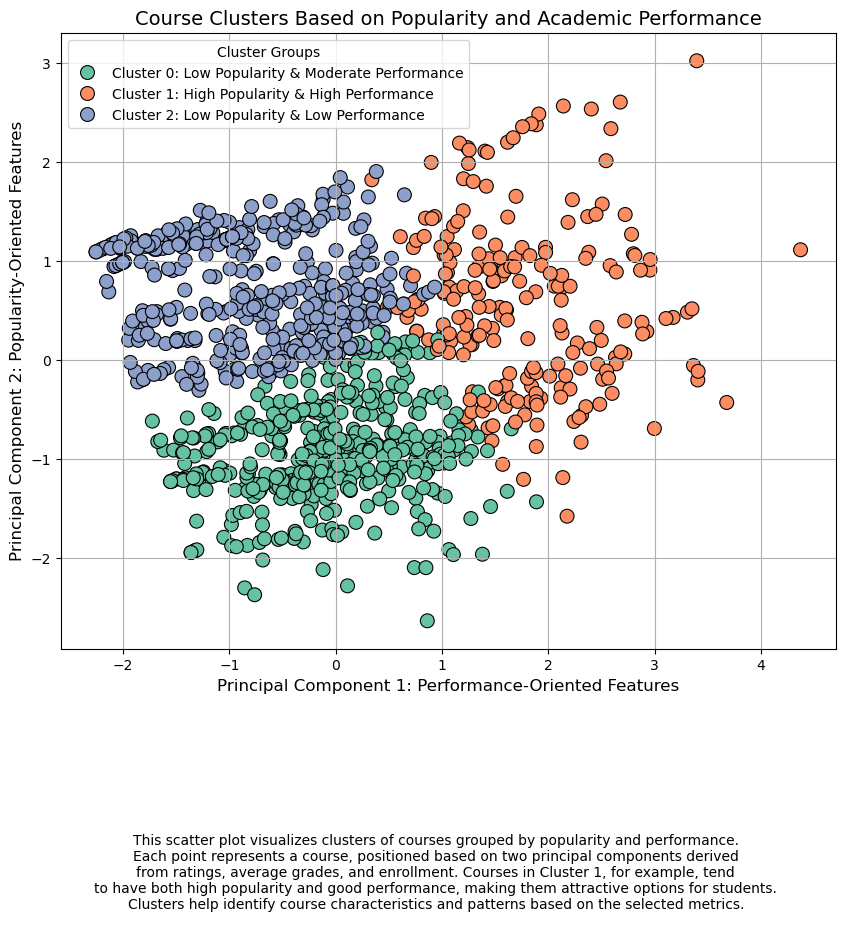

In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
gd_cs_14_24 = cs_grades
rmp_cs_14_24 = cs_rmp
cs_descrip = cs_descrip

# Calculate average grade for each course in gd_cs_14_24
gd_cs_14_24['Total Grades'] = gd_cs_14_24[['A', 'B', 'C', 'D', 'F']].sum(axis=1)
gd_cs_14_24['Average Grade'] = (
    gd_cs_14_24['A'] * 4 + gd_cs_14_24['B'] * 3 + gd_cs_14_24['C'] * 2 + gd_cs_14_24['D'] * 1
) / gd_cs_14_24['Total Grades']

# Merge gd_cs_14_24 with rmp_cs_14_24 on 'Primary Instructor' and 'Instructor'
data = pd.merge(
    gd_cs_14_24,
    rmp_cs_14_24,
    left_on='Instructor',
    right_on='Instructor',
    how='left'
)

# Convert 'CRS NBR' in both dataframes to strings to enable merging
data['CRS NBR'] = data['CRS NBR'].astype(str)
cs_descrip['Course'] = cs_descrip['Course'].astype(str)

# Merge with cs_descrip on 'CRS SUBJ CD' and 'CRS NBR'
data = pd.merge(
    data,
    cs_descrip,
    left_on=['CRS SUBJ CD', 'CRS NBR'],
    right_on=['Course', 'Course Title'],
    how='left'
)

# Replace missing RMP ratings with the default value of 5
data['Rating'] = data['Rating'].fillna(5)

# Ensure there are no NaNs in selected features by filling remaining missing values with column means
features = data[['Average Grade', 'Rating', 'Grade Regs']].fillna(data[['Average Grade', 'Rating', 'Grade Regs']].mean())

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply KMeans and PCA
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(features_scaled)
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)

# Add clusters to the dataset for labeling
data['Cluster'] = clusters

import matplotlib.pyplot as plt
import seaborn as sns

# Plot clusters with additional information
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    x=features_2d[:, 0],
    y=features_2d[:, 1],
    hue=clusters,
    palette="Set2",
    s=100,
    edgecolor="black"
)

# Title and axis labels
plt.title("Course Clusters Based on Popularity and Academic Performance", fontsize=14)
plt.xlabel("Principal Component 1: Performance-Oriented Features", fontsize=12)
plt.ylabel("Principal Component 2: Popularity-Oriented Features", fontsize=12)

caption = """
This scatter plot visualizes clusters of courses grouped by popularity and performance.
Each point represents a course, positioned based on two principal components derived
from ratings, average grades, and enrollment. Courses in Cluster 1, for example, tend
to have both high popularity and good performance, making them attractive options for students.
Clusters help identify course characteristics and patterns based on the selected metrics.
"""

# Add legend with clearer descriptions
legend = plt.legend(title="Cluster Groups")
legend.texts[0].set_text("Cluster 0: Low Popularity & Moderate Performance")  # Example; adjust based on clusters
legend.texts[1].set_text("Cluster 1: High Popularity & High Performance")
legend.texts[2].set_text("Cluster 2: Low Popularity & Low Performance")

plt.figtext(0.5, -0.1, caption, ha="center", va="top", fontsize=10, wrap=True)

# Display the plot
plt.grid(True)
plt.show()



#### 2 Grade Distribution by Course Level

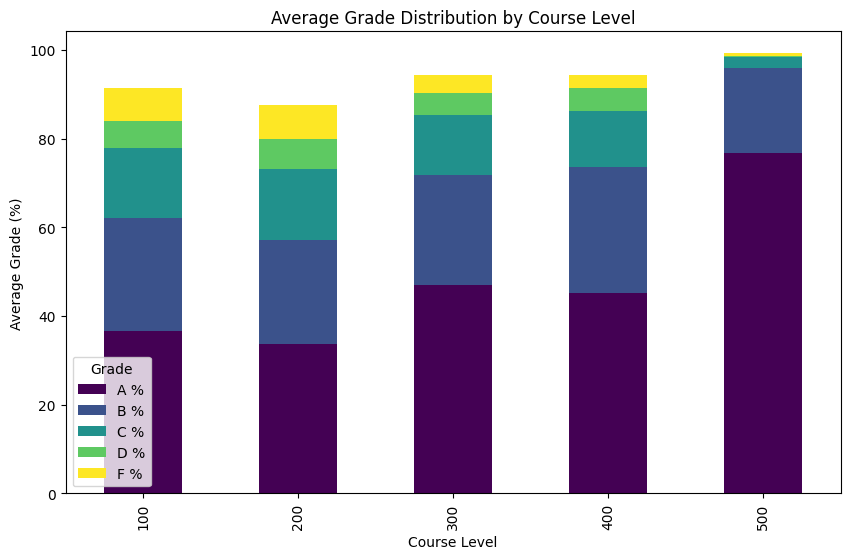

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
data = cs_grades
# Add a new column to categorize course numbers into levels (e.g., 100, 200, 300, etc.)
data['Course Level'] = (data['CRS NBR'] // 100) * 100

# Calculate total number of registered students per course
data['Total Registered'] = data[['A', 'B', 'C', 'D', 'F', 'W']].sum(axis=1)

# Calculate the grade distribution as a percentage of the total registered students
for grade in ['A', 'B', 'C', 'D', 'F']:
    data[f'{grade} %'] = (data[grade] / data['Total Registered']) * 100

# Aggregate average grade distribution by course level
grade_distribution = data.groupby('Course Level')[[f'{grade} %' for grade in ['A', 'B', 'C', 'D', 'F']]].mean()

# Plot grade distribution by course level
grade_distribution.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title("Average Grade Distribution by Course Level")
plt.xlabel("Course Level")
plt.ylabel("Average Grade (%)")
plt.legend(title="Grade")
plt.show()


#### 5 Withdrawal rate by course level

C:\Users\nandi\AppData\Local\Temp\ipykernel_24260\674005309.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=withdrawal_rate_course_level.index, y=withdrawal_rate_course_level.values, palette="magma")


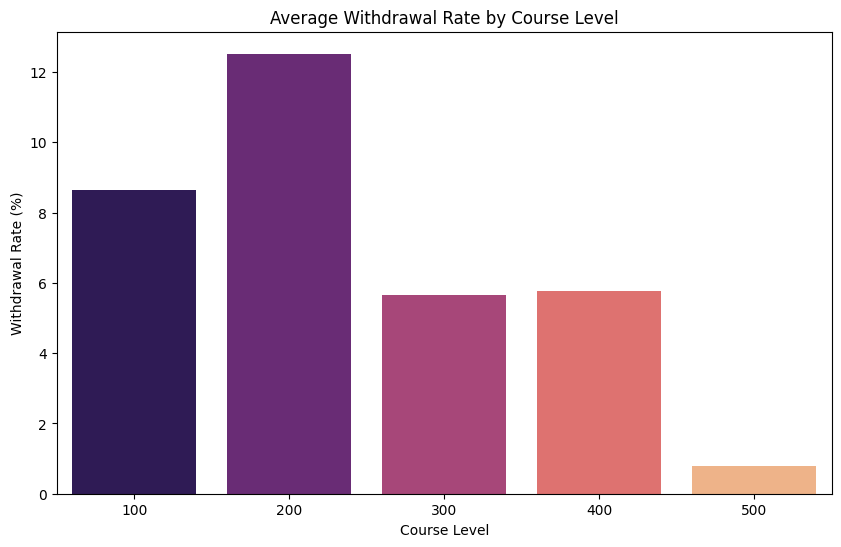

In [20]:
# Calculate withdrawal rate as a percentage of total registered students
data['Withdrawal Rate (%)'] = (data['W'] / data['Total Registered']) * 100

# Aggregate average withdrawal rate by course level
withdrawal_rate_course_level = data.groupby('Course Level')['Withdrawal Rate (%)'].mean().sort_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=withdrawal_rate_course_level.index, y=withdrawal_rate_course_level.values, palette="magma")
plt.title("Average Withdrawal Rate by Course Level")
plt.xlabel("Course Level")
plt.ylabel("Withdrawal Rate (%)")
plt.show()




#### 6 Grade distribution between semesters

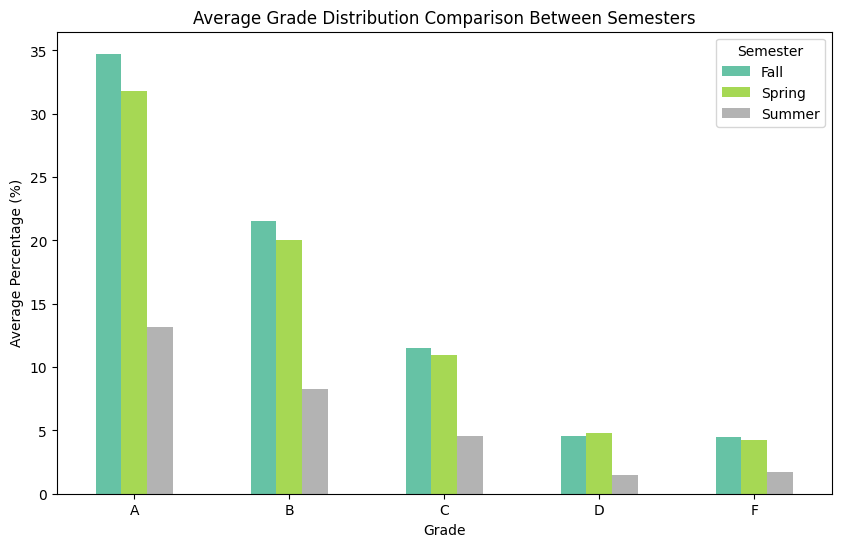

In [21]:
# Calculate average grade distribution for Fall and Spring semesters
semester_grades = data.groupby('SEMESTER')[['A', 'B', 'C', 'D', 'F']].mean()

# Plot side-by-side bar chart
semester_grades.T.plot(kind='bar', figsize=(10, 6), colormap="Set2")
plt.title("Average Grade Distribution Comparison Between Semesters")
plt.xlabel("Grade")
plt.ylabel("Average Percentage (%)")
plt.xticks(rotation=0)
plt.legend(title="Semester")
plt.show()


#### **9 Online and in-person course**
9.1 Online Course Percentage by Year for Different Departments-line chart  
9.2 Online Course Percentage by Year and semeter for Different Departments - histogram  
9.3 Average Grade Distribution by Year and Course Type - Stacked bar chart


##### 9.1 Online Course Percentage by Year for Different Departments-line chart 

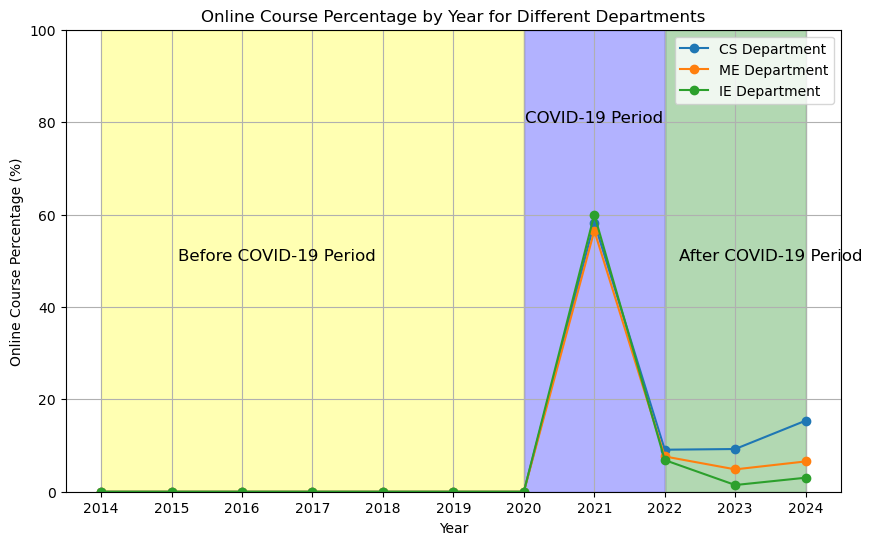

In [10]:
# Part 1
# Online Course Percentage by Year for Different Departments - line chart

# get data in CS department
cs_data = cs_lectures
# mark online course
cs_data['Is_Online'] = cs_data['Method'].str.contains('Online', case=False, na=False)
# calculate the ratio of online course for each year
cs_online_ratio_by_year = cs_data.groupby('Year')['Is_Online'].mean() * 100
# Create new table
cs_online_ratio_df = cs_online_ratio_by_year.reset_index()
cs_online_ratio_df.columns = ['Year', 'Online_Course_Percentage']
#print(cs_online_ratio_df)

# get data in IE department
ie_data = ie_lectures
# mark online course
ie_data['Is_Online'] = ie_data['Method'].str.contains('Online', case=False, na=False)
# calculate the ratio of online course for each year
ie_online_ratio_by_year = ie_data.groupby('Year')['Is_Online'].mean() * 100
# Create new table
ie_online_ratio_df = ie_online_ratio_by_year.reset_index()
ie_online_ratio_df.columns = ['Year', 'Online_Course_Percentage']
#print(ie_online_ratio_df)

# get data in ME department
me_data = me_lectures
# mark online course
me_data['Is_Online'] = me_data['Method'].str.contains('Online', case=False, na=False)
# calculate the ratio of online course for each year
me_online_ratio_by_year = me_data.groupby('Year')['Is_Online'].mean() * 100
# Create new table
me_online_ratio_df = me_online_ratio_by_year.reset_index()
me_online_ratio_df.columns = ['Year', 'Online_Course_Percentage']
#print(me_online_ratio_df)

plt.figure(figsize=(10, 6))
plt.plot(cs_online_ratio_df['Year'], cs_online_ratio_df['Online_Course_Percentage'], marker='o', linestyle='-', label='CS Department')
plt.plot(me_online_ratio_df['Year'], me_online_ratio_df['Online_Course_Percentage'], marker='o', linestyle='-', label='ME Department')
plt.plot(ie_online_ratio_df['Year'], ie_online_ratio_df['Online_Course_Percentage'], marker='o', linestyle='-', label='IE Department')

# add background
plt.axvspan(2014, 2020, color='yellow', alpha=0.3)
plt.text(2016.5, 50, 'Before COVID-19 Period', color='black', fontsize=12, ha='center')
plt.axvspan(2020, 2022, color='blue', alpha=0.3)
plt.text(2021, 80, 'COVID-19 Period', color='black', fontsize=12, ha='center')
plt.axvspan(2022, 2024, color='green', alpha=0.3)
plt.text(2023.5, 50, 'After COVID-19 Period', color='black', fontsize=12, ha='center')


plt.title('Online Course Percentage by Year for Different Departments')
plt.xlabel('Year')
plt.ylabel('Online Course Percentage (%)')

plt.xticks(range(2014, 2025))
plt.ylim(0, 100)

plt.legend()
plt.grid(True)
plt.show()


Finding1: Changes in Online Course Proportion:

1. Before COVID-19 Period, the proportion of online courses across all departments was nearly 0%, indicating that online teaching was not a primary mode of instruction before the pandemic.  
2. During COVID-19 Period, the proportion of online courses in all departments suddenly increased sharply, reaching nearly 100%.  
3. After COVID-19 Period, the proportion of online courses dropped significantly and stabilized. This indicates that after the pandemic, some courses returned to in-person instruction, although some habits of online teaching might have remained, especially in the CS department, which still had a relatively high proportion of online courses in 2023-2024.  
   
Finding2: Differences Among Departments:

1. During the COVID-19 period, the proportion of online courses was similar across all departments, indicating that under special circumstances, all disciplines transitioned to online teaching.  
2. After the the COVID-19 period, we can see that the CS department (blue line) retained more online courses, while the ME and IE departments largely returned to nearly 0% online courses.

##### 9.2 Online Course Percentage by Year and semeter for Different Departments - histogram

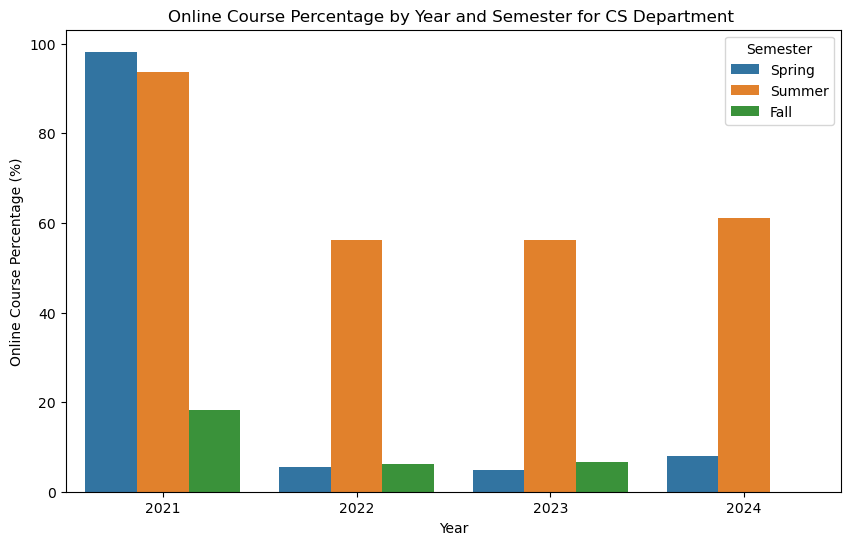

In [12]:
# Part2 
# Online Course Percentage by Year and semester for Different Departments - histogram
# CS Department
# calculate the ratio of online course for each semester
cs_online_ratio_by_semester = cs_data.groupby(['Year','Semester'])['Is_Online'].mean() * 100
# Create new table
cs_online_ratio_by_semester_df = cs_online_ratio_by_semester.reset_index()
cs_online_ratio_by_semester_df.columns = ['Year','Semester', 'Online_Course_Percentage']
# change the semester
semester_order = ["Spring", "Summer", "Fall"]
cs_online_ratio_by_semester_df['Semester'] = pd.Categorical(cs_online_ratio_by_semester_df['Semester'], categories=semester_order, ordered=True)
#print(cs_online_ratio_by_semester_df)
cs_online_ratio_by_semester_df['Year'] = cs_online_ratio_by_semester_df['Year'].astype(int)
cs_online_ratio_by_semester_df = cs_online_ratio_by_semester_df[(cs_online_ratio_by_semester_df['Year'] >= 2021) & (cs_online_ratio_by_semester_df['Year'] <= 2024)]

plt.figure(figsize=(10, 6))
sns.barplot(data=cs_online_ratio_by_semester_df, x="Year", y="Online_Course_Percentage", hue="Semester",dodge=True)

plt.title("Online Course Percentage by Year and Semester for CS Department ")
plt.xlabel("Year")
plt.ylabel("Online Course Percentage (%)")
plt.legend(title="Semester")

plt.show()

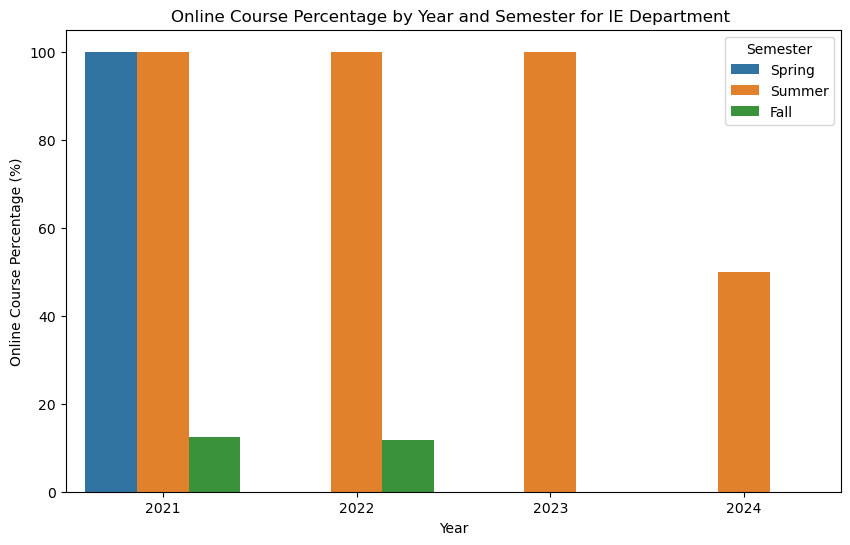

In [13]:
# Part2 
# Online Course Percentage by Year and semester for Different Departments - histogram
# IE Department
# calculate the ratio of online course for each semester
ie_online_ratio_by_semester = ie_data.groupby(['Year','Semester'])['Is_Online'].mean() * 100
# Create new table
ie_online_ratio_by_semester_df = ie_online_ratio_by_semester.reset_index()
ie_online_ratio_by_semester_df.columns = ['Year','Semester', 'Online_Course_Percentage']
# change the semester
ie_online_ratio_by_semester_df['Semester'] = pd.Categorical(ie_online_ratio_by_semester_df['Semester'], categories=semester_order, ordered=True)
#print(cs_online_ratio_by_semester_df)
ie_online_ratio_by_semester_df = ie_online_ratio_by_semester_df[(ie_online_ratio_by_semester_df['Year'] >= 2021) & (ie_online_ratio_by_semester_df['Year'] <= 2024)]

plt.figure(figsize=(10, 6))
sns.barplot(data=ie_online_ratio_by_semester_df, x="Year", y="Online_Course_Percentage", hue="Semester",dodge=True)

plt.title("Online Course Percentage by Year and Semester for IE Department ")
plt.xlabel("Year")
plt.ylabel("Online Course Percentage (%)")
plt.legend(title="Semester")

plt.show()

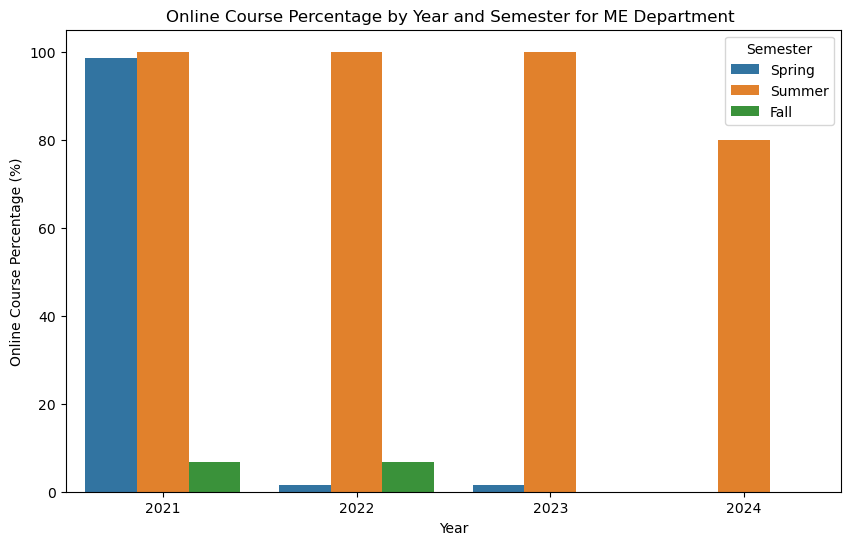

In [14]:
# Part2 
# Online Course Percentage by Year and semester for Different Departments - histogram
# ME Department
# calculate the ratio of online course for each semester
me_online_ratio_by_semester = me_data.groupby(['Year','Semester'])['Is_Online'].mean() * 100
# Create new table
me_online_ratio_by_semester_df = me_online_ratio_by_semester.reset_index()
me_online_ratio_by_semester_df.columns = ['Year','Semester', 'Online_Course_Percentage']
# change the semester
me_online_ratio_by_semester_df['Semester'] = pd.Categorical(me_online_ratio_by_semester_df['Semester'], categories=semester_order, ordered=True)
#print(cs_online_ratio_by_semester_df)
me_online_ratio_by_semester_df = me_online_ratio_by_semester_df[(me_online_ratio_by_semester_df['Year'] >= 2021) & (me_online_ratio_by_semester_df['Year'] <= 2024)]
plt.figure(figsize=(10, 6))
sns.barplot(data=me_online_ratio_by_semester_df, x="Year", y="Online_Course_Percentage", hue="Semester",dodge=True)

plt.title("Online Course Percentage by Year and Semester for ME Department ")
plt.xlabel("Year")
plt.ylabel("Online Course Percentage (%)")
plt.legend(title="Semester")

plt.show()

Finding: Most of the online courses are concentrated in the summer semester after COVID-19 for every department.

##### 9.3 Average Grade Distribution by Year and Course Type - Stacked bar chart

In [ ]:
#Part3 Average Grade Distribution by Year and Course Type - Stacked bar chart
# 
from matplotlib.patches import Patch

def visualize_grade_distribution(file_grade, file_course):
    # import data
    table_cs_grade = file_grade
    table_cs_course = file_course

    # update data formate
    table_cs_course[['CRS SUBJ CD', 'CRS NBR']] = table_cs_course['Course Code'].str.split(' ', expand=True)

    table_cs_grade['CRS NBR'] = table_cs_grade['CRS NBR'].astype(str)
    table_cs_course['CRS NBR'] = table_cs_course['CRS NBR'].astype(str)

    #merge table
    merged_cs_df_grade_course = pd.merge(
        table_cs_grade, 
        table_cs_course,
        how='inner',
        left_on=['CRS SUBJ CD','CRS NBR', 'YEAR', 'SEMESTER'],
        right_on=['CRS SUBJ CD','CRS NBR', 'Year', 'Semester']
        )
    #filter data 2021-2024
    filtered_cs_df_grade_course = merged_cs_df_grade_course[(merged_cs_df_grade_course['Year'] >= 2021) & (merged_cs_df_grade_course['Year'] <= 2024)]

    # create new table for grade proportion for online and on-campus course type
    def classify_method(method):
        if isinstance(method, str) and 'online' in method.lower():
            return 'Online'
        else:
            return 'OnCampus'
    filtered_cs_df_grade_course['Course Type'] = filtered_cs_df_grade_course['Method'].apply(classify_method)

    grade_columns = ['A', 'B', 'C', 'D', 'F']
    cs_grade_proportion_for_course_type = filtered_cs_df_grade_course.groupby(['Year', 'Course Type'])[grade_columns].sum().reset_index()
    for grade in grade_columns:
        cs_grade_proportion_for_course_type[grade + '_proportion'] = cs_grade_proportion_for_course_type[grade] / cs_grade_proportion_for_course_type[grade_columns].sum(axis=1)*100

    #print(cs_grade_proportion_for_course_type)

    pivot_df = cs_grade_proportion_for_course_type.pivot(index='Year', columns='Course Type')

    # define the color
    course_colors = {'Online': ['#4daf4a', '#6aeb6a', '#8cf58c', '#b1fdb1', '#d4ffd4'],
                    'OnCampus': ['#377eb8', '#5696db', '#74aef5', '#9bcdfd', '#c2e6ff']}
    proportion_columns = ['A_proportion', 'B_proportion', 'C_proportion', 'D_proportion', 'F_proportion']
    fig, ax = plt.subplots(figsize=(12, 8))

    course_types = ['Online', 'OnCampus']
    x = pivot_df.index
    width = 0.4

    bars = []
    labels = []

    for course_type_index, course_type in enumerate(course_types):
        bottom_values = None
        for i, grade in enumerate(proportion_columns):
            values = pivot_df[(grade, course_type)].fillna(0)
            bar = ax.bar(x + (course_type_index - 0.5) * width, values, width=width, 
                        bottom=bottom_values, color=course_colors[course_type][i], alpha=0.8)
            if i == 0:
                bars.append(bar)
                labels.append(f'{course_type}')

            if bottom_values is None:
                bottom_values = values
            else:
                bottom_values += values

    # add legend
    grade_legend = [
    Patch(color=course_colors['Online'][i], label=f'Online Grade {grade.split("_")[0]}') for i, grade in enumerate(proportion_columns)] + [
    Patch(color=course_colors['OnCampus'][i], label=f'OnCampus Grade {grade.split("_")[0]}') for i, grade in enumerate(proportion_columns)]  
    plt.legend(handles=grade_legend, title='Course Type and Grade', bbox_to_anchor=(1.05, 1), loc='upper left')



### **Part 5: Machine Learning Analysis**

## **Reflection**

**What is the hardest part of the project that you’ve encountered so far?**


<br>**What are your initial insights?**


<br>**Are there any concrete results you can show at this point? If not, why not?**


<br>**Going forward, what are the current biggest problems you’re facing?**


<br>**Do you think you are on track with your project? If not, what parts do you need to dedicate more time to?**


<br>**Given your initial exploration of the data, is it worth proceeding with your project, why? If not, how are you going to change your project and why do you think it’s better than your current results?**



## **Roles/Coordination (important)**

**Arlette Diaz:** 
* Cleaned the grade distribution data set for Comupter Science classes
* Cleaned the grade distribution data set for MEIE classes
* Cleaned the lecutre data set for all classes (CS, IE, ME)

<br>**Marianne Hernandez:** 
* Scraped the data for Computer Science course offerings between Spring 2014 - Summer 2024
* Scraped the data for Mechanical Engineering course offerings between Spring 2014 - Summer 2024
* Scraped the data for Industrial Engineering course offerings between Spring 2014 - Summer 2024
* Converted data into .csv files for group to use after cleaning up and reorganizing relevant information
* Worked on ERD section

<br>**Nandini Jirobe:** 
* Collected Rate My Professor ratings for professors who taught Mechanical and Industrial Enginnering classes from 2014-2024
* Collected Rate My Professor ratings for professors in the Computer Science classes from 2014-2024
* Collected Google Scholar research interests of professors who taught Mechanical and Industrial Enginnering classes from 2014-2024
* Collected Google Scholar research interests of professors in the Computer Science classes from 2014-2024
* Collected course description data for computer science courses taught at UIC. 

<br>**Sharadruthi Muppidi:** 
* Text

<br>**Sonina Mut:** 
* Collected UIC Grade Distribution for professors who taught Mechanical and Industrial Enginnering classes from 2014-2024
* Collected UIC Grade Distribution for professors in the Computer Science classes from 2014-2024
* Collected Rate My Professor ratings for professors who taught Mechanical and Industrial Enginnering classes from 2014-2024
* Collected Rate My Professor ratings for professors in the Computer Science classes from 2014-2024
* Completed Data Clean, Dataset 2.1 for Rate My professor from 2014-2024
* Completed Data Clean, Dataset 2.2 for Rate My professor from 2014-2024

<br>**Yuting Lu:** 
* Came up with some data visualization ideas.
* Completed data visualizations 9(9.1-9.3) in part4.

## **Next Steps**